# 멀티 에이전트 협업 네트워크(Multi-Agent Collaboration Network)

**Multi-Agent Collaboration Network**는 여러 AI 에이전트들이 협력하여 복잡한 문제를 해결하는 시스템입니다.

### 핵심 개념

**기본 구조**
- 각 에이전트가 특정 역할이나 전문성을 가지고 있음
- 에이전트들이 서로 통신하고 정보를 공유하며 협업
- 중앙 조정자가 있거나, 분산형으로 자율적으로 협력

**주요 특징**
- **분업**: 복잡한 작업을 여러 에이전트가 나누어 처리
- **상호작용**: 에이전트 간 메시지 전달, 결과 공유, 피드백 교환
- **시너지**: 단일 에이전트보다 더 나은 성과 달성

**활용 예시**
- 코딩 작업: 기획자, 개발자, 테스터 에이전트가 협력
- 연구 분석: 데이터 수집, 분석, 보고서 작성을 각각 담당
- 고객 서비스: 문의 분류, 답변 생성, 품질 검증 에이전트 협업

**장점**
- 복잡한 문제를 더 효과적으로 해결
- 각 에이전트의 전문성 활용
- 확장성과 유연성

- 참고 자료: https://wikidocs.net/270689
- 관련 논문: https://arxiv.org/abs/2308.08155
- Multi-agent systems 개념: https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network

## 환경 설정

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 상태 정의

In [3]:
from typing import Annotated
from langgraph.graph.message import MessagesState


class State(MessagesState):
    sender: Annotated[str, "마지막 메시지의 발신자"]

## 도구 정의

In [45]:
from langchain_core.tools import Tool
from langchain_tavily import TavilySearch
from langchain_experimental.utilities import PythonREPL

web_search_tool = TavilySearch(max_results=3)

python_repl = PythonREPL()
python_repl_tool = Tool(
    "python_repl",
    description="파이썬 Shell입니다. 파이썬 명령어를 실행하는 데 사용하세요. 입력은 유효한 파이썬 명령어여야 합니다. 값의 출력을 확인하려면 `print(...)`로 출력해야 합니다.",
    func=python_repl.run,
)

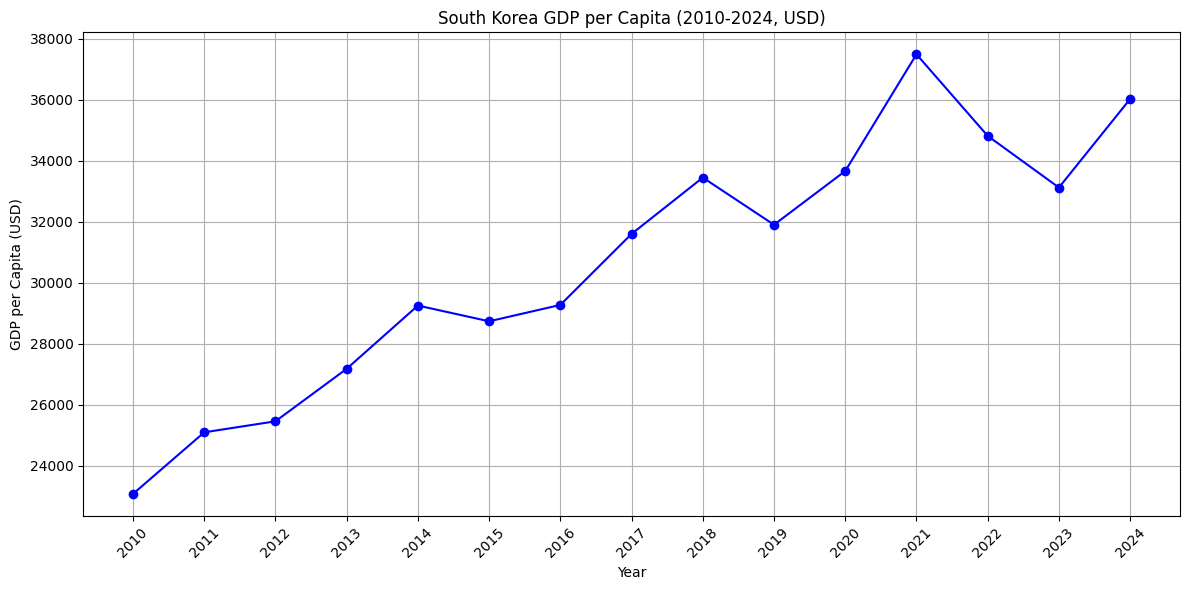

''

In [46]:
code = """import matplotlib.pyplot as plt

years = list(range(2010, 2025))
gdp_per_capita = [23079, 25098, 25459, 27180, 29253, 28737, 29274, 31601, 33447, 31902, 33663, 37488, 34814, 33121, 36024]

plt.figure(figsize=(12, 6))
plt.plot(years, gdp_per_capita, marker='o', linestyle='-', color='blue')
plt.title('South Korea GDP per Capita (2010-2024, USD)')
plt.xlabel('Year')
plt.ylabel('GDP per Capita (USD)')
plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()"""

python_repl_tool.invoke(code)

## Research Agent

웹 검색 도구를 사용하여 연구에 필요한 정보를 리서치하는 에이전트입니다.

In [56]:
from langgraph.prebuilt import create_react_agent

system_template = (
    "You are a helpful AI assistant, collaborating with other assistants."
    " Use the provided tools to progress towards answering the question."
    " If you are unable to fully answer, that's OK, another assistant with different tools "
    " will help where you left off. Execute what you can to make progress."
    " If you or any of the other assistants have the final answer or deliverable,"
    " prefix your response with FINAL ANSWER so the team knows to stop."
    "\n{instructions}"
)

research_agent = create_react_agent(
    model="openai:gpt-4o",
    tools=[web_search_tool],
    prompt=system_template.format(
        instructions="You can only do research. You are working with a chart generator colleague."
    ),
)

In [57]:
from langchain_core.messages import HumanMessage


def research_node(state: State):
    response = research_agent.invoke({"messages": state["messages"]})
    last_message = response["messages"][-1].content
    return {"messages": [HumanMessage(content=last_message, name="researcher")]}

## Chart Generator Agent

파이썬 코드를 사용하여 차트를 생성하는 에이전트입니다.

In [71]:
chart_generator_instructions = """You can only generate charts. You are working with a researcher colleague.

Be sure to use the Korean font code in your code when generating charts.

```python
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False 
```
"""

chart_generator_agent = create_react_agent(
    model="openai:gpt-4o",
    tools=[python_repl_tool],
    prompt=system_template.format(instructions=chart_generator_instructions),
)

In [72]:
def chart_generator_node(state: State):
    response = chart_generator_agent.invoke({"messages": state["messages"]})
    last_message = response["messages"][-1].content
    return {"messages": [HumanMessage(content=last_message, name="chart_generator")]}

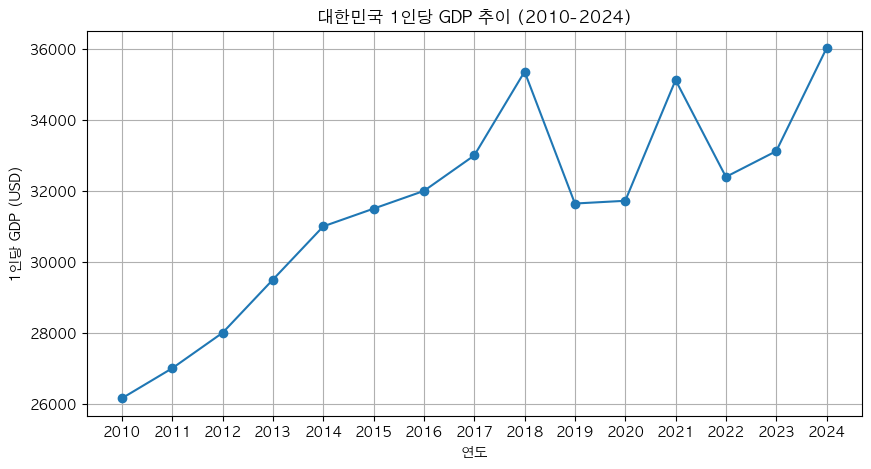

{'messages': [HumanMessage(content="The chart showcasing South Korea's per capita GDP trend from 2010 to 2024 has been successfully generated. Please check the graph for the visual representation of the data.", additional_kwargs={}, response_metadata={}, name='chart_generator')]}

In [73]:
query = """2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요.

대한민국 2010년부터 2024년까지 1인당 GDP(미국 달러 기준) 주요 연도별 데이터는 다음과 같습니다.

- 2010년: 약 26,153 USD
- 2018년: 약 35,364 USD
- 2019년: 약 31,644 USD
- 2020년: 약 31,721 USD
- 2021년: 약 35,126 USD
- 2022년: 약 32,395 USD
- 2023년: 약 33,121 USD
- 2024년: 약 36,024 USD (예상치)

이 데이터를 토대로 대한민국 2010년부터 2024년까지의 1인당 GDP 추이 그래프를 생성하겠습니다.
대한민국 2010년부터 2024년까지의 1인당 GDP 추이를 시각화하기 위해 아래와 같은 연도별 데이터 포인트를 추정하였습니다.

- 2010: 26,153 USD  
- 2011: 27,000 USD (추정)  
- 2012: 28,000 USD (추정)  
- 2013: 29,500 USD (추정)  
- 2014: 31,000 USD (추정)  
- 2015: 31,500 USD (추정)  
- 2016: 32,000 USD (추정)  
- 2017: 33,000 USD (추정)  
- 2018: 35,364 USD  
- 2019: 31,644 USD  
- 2020: 31,721 USD  
- 2021: 35,126 USD  
- 2022: 32,395 USD  
- 2023: 33,121 USD  
- 2024: 36,024 USD

이 데이터를 기반으로 그래프를 생성하도록 하겠습니다. 잠시 기다려 주세요."""
chart_generator_node({"messages": [("user", query)]})

## 그래프 작성

In [74]:
from typing import Literal
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver


def should_continue(state: State) -> Literal["continue", END]:
    last_message = state["messages"][-1].content
    if "FINAL ANSWER" in last_message:
        return END
    else:
        return "continue"


builder = StateGraph(State)
builder.add_node(research_node)
builder.add_node(chart_generator_node)

builder.add_conditional_edges(
    research_node.__name__,
    should_continue,
    {
        "continue": chart_generator_node.__name__,
        END: END,
    },
)

builder.add_conditional_edges(
    chart_generator_node.__name__,
    should_continue,
    {
        "continue": research_node.__name__,
        END: END,
    },
)

builder.set_entry_point(research_node.__name__)
graph = builder.compile(checkpointer=InMemorySaver())


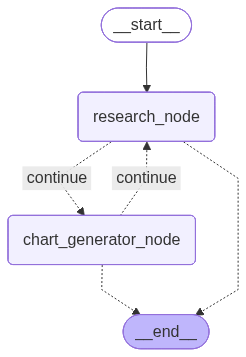

In [75]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

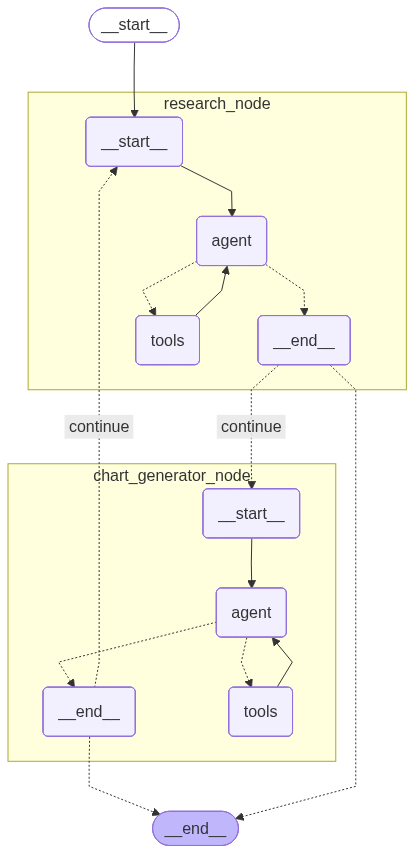

In [76]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## 그래프 실행


##### RESEARCH_NODE #####
================================ Human Message =================================
Name: researcher

I was unable to find Korea's exact per capita GDP data from 2010 to 2024, however using available data from official sites I was able to find the following (in U.S. dollars):

- 2011: 26,177.94
- 2012: 26,600.55
- 2013: 28,449.36
- 2014: 30,667.09
- 2015: 30,171.79
- 2016: 30,825.52
- 2017: 33,296.98
- 2018: 35,363.95
- 2019: 33,826.94
- 2020: 33,653.2
- 2021: 37,518.47
- 2022: 34,822.41 (estimated)
- 2023: 35,563.05 (forecasted)
- 2024: 36,128.99 (forecasted)

Please proceed to visualize this data into a graph.


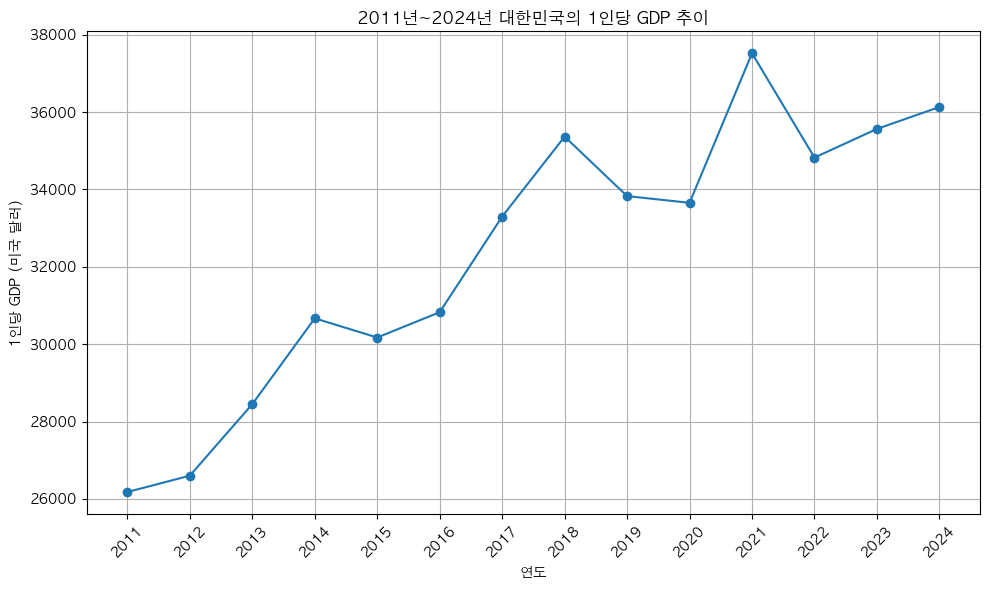


##### CHART_GENERATOR_NODE #####
================================ Human Message =================================
Name: chart_generator

I'm unable to generate the graph directly, but here's the Python code you can run in your local environment to visualize the data:

```python
import matplotlib.pyplot as plt

# Set Korean font for matplotlib
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

# Data for South Korea's GDP per capita from 2011 to 2024
years = list(range(2011, 2025))
gdp_per_capita = [26177.94, 26600.55, 28449.36, 30667.09, 30171.79, 30825.52, 33296.98, 35363.95, 33826.94, 33653.2, 37518.47, 34822.41, 35563.05, 36128.99]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_per_capita, marker='o')
plt.title('2011년~2024년 대한민국의 1인당 GDP 추이')
plt.xlabel('연도')
plt.ylabel('1인당 GDP (미국 달러)')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()
```

By running this code, you will be able to see the trend of South 

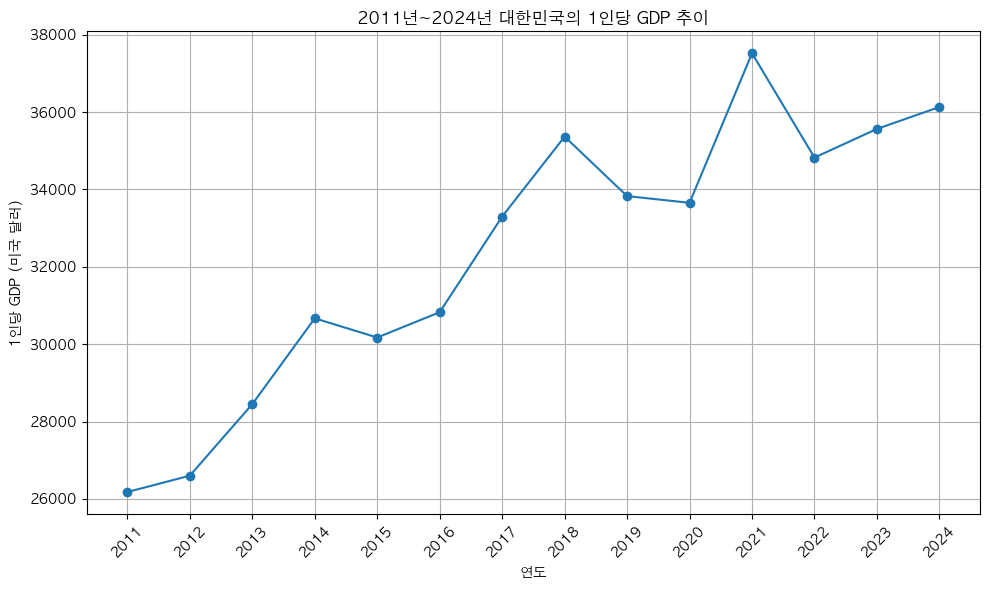


##### CHART_GENERATOR_NODE #####
================================ Human Message =================================
Name: chart_generator

It seems like the output was unsuccessful due to technical limitations of this environment. However, you can use the following Python code on your local machine to generate the graph:

```python
import matplotlib.pyplot as plt

# Set Korean font for matplotlib
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

# Data for South Korea's GDP per capita from 2011 to 2024
years = list(range(2011, 2025))
gdp_per_capita = [26177.94, 26600.55, 28449.36, 30667.09, 30171.79, 30825.52, 33296.98, 35363.95, 33826.94, 33653.2, 37518.47, 34822.41, 35563.05, 36128.99]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_per_capita, marker='o')
plt.title('2011년~2024년 대한민국의 1인당 GDP 추이')
plt.xlabel('연도')
plt.ylabel('1인당 GDP (미국 달러)')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()
```

By running t

In [79]:
from langchain_core.runnables import RunnableConfig
from datetime import datetime

config = RunnableConfig(
    recursion_limit=50,
    configurable={"thread_id": int(datetime.today().timestamp())},
)

query = "2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
for event in graph.stream(
    {"messages": [("user", query)]},
    config=config,
    stream_mode="updates",
):
    for key, values in event.items():
        print(f"\n##### {key.upper()} #####")
        values["messages"][-1].pretty_print()